/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and preprocessing data...


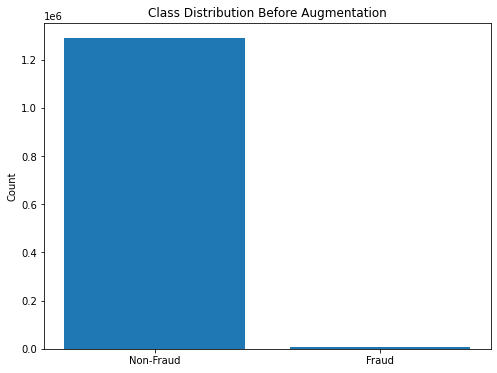


Initializing models...

Starting training...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (7506x4 and 128x4)

In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, r2_score, matthews_corrcoef
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Data preprocessing functions
def df_label_encoder(df, columns):
    """Encode categorical columns using LabelEncoder"""
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def preprocess(df):
    """Preprocess the dataset and extract features for node creation"""
    # Encode categorical columns
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    
    # Normalize amount column
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    
    # Create node mappings
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    
    # Get unique nodes
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

def create_graph_data(df, node_list):
    """Create graph data structures from DataFrame"""
    # Create node mapping
    node_map = {node: idx for idx, node in enumerate(node_list)}
    
    # Create edge index
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] 
        for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T
    
    # Convert to torch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)
    
    return node_features, edge_index, labels

class GATLayer(nn.Module):
    """Graph Attention Layer"""
    def __init__(self, in_features, out_features, n_heads=4, dropout=0.6, alpha=0.2):
        super(GATLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.n_heads = n_heads
        self.alpha = alpha

        # Linear transformation for each attention head
        self.W = nn.Parameter(torch.zeros(size=(n_heads, in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        # Attention parameters for each head
        self.a = nn.Parameter(torch.zeros(size=(n_heads, 2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # Leaky ReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, x, edge_index):
        H = torch.stack([F.linear(x, self.W[i]) for i in range(self.n_heads)])
        
        # Prepare edge features
        edge_src, edge_dst = edge_index
        
        # Initialize attention coefficients
        N = x.size(0)
        E = edge_src.size(0)
        
        # Compute attention coefficients for each head
        attention = torch.zeros(self.n_heads, E).to(x.device)
        
        for h in range(self.n_heads):
            # Compute attention coefficients
            edge_features = torch.cat([
                H[h, edge_src],
                H[h, edge_dst]
            ], dim=1)
            
            # Calculate attention scores
            attention[h] = self.leakyrelu(torch.mm(edge_features, self.a[h])).squeeze(1)
        
        # Apply softmax to normalize attention coefficients
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        
        # Apply attention coefficients
        out = torch.zeros(self.n_heads, N, self.out_features).to(x.device)
        
        for h in range(self.n_heads):
            # Aggregate features using attention
            for i in range(E):
                out[h, edge_dst[i]] += attention[h, i] * H[h, edge_src[i]]
        
        # Combine heads
        out = torch.mean(out, dim=0)
        return out

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_heads=4):
        super(Generator, self).__init__()
        self.gat1 = GATLayer(input_size, hidden_size, n_heads=n_heads)
        self.gat2 = GATLayer(hidden_size, output_size, n_heads=n_heads)
        self.dropout = nn.Dropout(0.6)
        self.final_activation = nn.Sigmoid()

    def forward(self, z, edge_index):
        x = self.gat1(z, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        return self.final_activation(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, n_heads=4):
        super(Discriminator, self).__init__()
        self.gat1 = GATLayer(input_size, hidden_size, n_heads=n_heads)
        self.gat2 = GATLayer(hidden_size, 1, n_heads=n_heads)
        self.dropout = nn.Dropout(0.6)
        self.final_activation = nn.Sigmoid()

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        return self.final_activation(x)

# Visualization functions
def plot_class_distribution(y_data, title):
    """Plot class distribution histogram"""
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.ylabel('Count')
    plt.show()

def plot_metrics(metrics_history):
    """Plot training metrics over time"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics_history['d_loss'], label='Discriminator Loss')
    plt.plot(metrics_history['g_loss'], label='Generator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics_history['accuracy'], label='Accuracy')
    plt.plot(metrics_history['auc_roc'], label='AUC-ROC')
    plt.title('Performance Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(discriminator, node_features, edge_index, labels):
    """Evaluate model performance and print metrics"""
    with torch.no_grad():
        pred_probs = discriminator(node_features, edge_index)
        pred_labels = (pred_probs > 0.5).float()

    # Convert to numpy for metric calculation
    y_true = labels.numpy()
    y_pred = pred_labels.numpy()
    y_prob = pred_probs.numpy()

    # Calculate metrics
    metrics = {
        'AUC-ROC': roc_auc_score(y_true, y_prob),
        'F1 Score': f1_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'R2 Score': r2_score(y_true, y_prob),
        'MCC': matthews_corrcoef(y_true, y_pred)
    }

    # Print metrics
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

    return metrics

def train_gan(generator, discriminator, node_features, edge_index, labels, 
              num_epochs=10, latent_size=64, batch_size=32):
    """Train the GAN model"""
    
    # Initialize optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    
    # Get real data
    real_data = node_features[labels == 1]
    target_minority_class = torch.sum(labels == 0)
    
    # Training history
    metrics_history = {
        'd_loss': [], 'g_loss': [], 
        'accuracy': [], 'auc_roc': []
    }
    
    for epoch in range(num_epochs):
        current_minority_count = torch.sum(labels == 1)
        if current_minority_count >= target_minority_class:
            break
        
        # Train discriminator
        optimizer_d.zero_grad()
        
        # Real data
        d_real = discriminator(real_data, edge_index)
        real_labels = torch.ones(d_real.shape)
        loss_real = loss_fn(d_real, real_labels)
        
        # Fake data
        z = torch.randn(real_data.size(0), latent_size)
        fake_data = generator(z, edge_index)
        d_fake = discriminator(fake_data.detach(), edge_index)
        fake_labels = torch.zeros(d_fake.shape)
        loss_fake = loss_fn(d_fake, fake_labels)
        
        # Total discriminator loss
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()
        
        # Train generator
        optimizer_g.zero_grad()
        d_fake = discriminator(fake_data, edge_index)
        loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
        loss_g.backward()
        optimizer_g.step()
        
        # Update dataset
        with torch.no_grad():
            labels = torch.cat((labels, torch.ones(fake_data.size(0), dtype=torch.long)))
            node_features = torch.cat((node_features, fake_data))
        
        # Calculate metrics
        if epoch % 2 == 0:
            metrics = evaluate_model(discriminator, node_features, edge_index, labels)
            metrics_history['d_loss'].append(loss_d.item())
            metrics_history['g_loss'].append(loss_g.item())
            metrics_history['accuracy'].append(metrics['Accuracy'])
            metrics_history['auc_roc'].append(metrics['AUC-ROC'])
            
            print(f'Epoch [{epoch}/{num_epochs}]:')
            print(f'D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}')
            print(f'Accuracy: {metrics["Accuracy"]:.4f}, AUC-ROC: {metrics["AUC-ROC"]:.4f}\n')
    
    return generator, discriminator, node_features, labels, metrics_history

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = pd.read_csv('creditcard/fraudTrain.csv')
    df, node_list = preprocess(df)
    node_features, edge_index, labels = create_graph_data(df, node_list)
    
    # Plot initial class distribution
    plot_class_distribution(labels, "Class Distribution Before Augmentation")
    
    # Model parameters
    input_size = node_features.shape[1]
    hidden_size = 128
    output_size = input_size
    latent_size = 64
    
    # Initialize models
    print("\nInitializing models...")
    generator = Generator(latent_size, hidden_size, output_size)
    discriminator = Discriminator(input_size, hidden_size)
    
    # Train models
    print("\nStarting training...")
    generator, discriminator, augmented_features, augmented_labels, metrics_history = train_gan(
        generator, discriminator, node_features, edge_index, labels,
        num_epochs=10, latent_size=latent_size
    )
    
    # Plot final results
    print("\nPlotting final results...")
    plot_class_distribution(augmented_labels, "Class Distribution After Augmentation")
    plot_metrics(metrics_history)
    
    # Final evaluation
    print("\nFinal model evaluation:")
    evaluate_model(discriminator, augmented_features, edge_index, augmented_labels)

if __name__ == "__main__":
    main()